# Analysis of multisample

This notebook performs multisample analysis on data that is created with the sparrow multisample runs.

***Please adjust the path of the folder below to the path of the multirun you want to analyze***

In [7]:
path_folder = "/home/smon/Documents/unief/bio/design-project/2022-11-16_16-30-37/"

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import squidpy as sq
from skimage import io
import scanpy as sc
import matplotlib.pyplot as plt
from anndata import AnnData
import yaml
from yaml.loader import SafeLoader
from typing import List
import time
import os
from dotenv import load_dotenv

Python-dotenv could not parse statement starting at line 10
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 15
Python-dotenv could not parse statement starting at line 16
Python-dotenv could not parse statement starting at line 18
Python-dotenv could not parse statement starting at line 20
Python-dotenv could not parse statement starting at line 22
Python-dotenv could not parse statement starting at line 23
Python-dotenv could not parse statement starting at line 24
Python-dotenv could not parse statement starting at line 25
Python-dotenv could not parse statement starting at line 26
Python-dotenv could not parse statement starting at line 27
Python-dotenv could not parse statement starting at line 31
Python-dotenv could not parse statement starting at line 33
Python-dotenv could not parse statement starting at line 38
Python-dotenv could not parse statement starting at line 39
Python-dotenv could not parse statement 

In [3]:
from napari_sparrow import functions as fc

## Read in the data

In [ ]:
import geopandas

def read_in(path_folder: str) -> AnnData:
    # Find all sample folders
    folders = [ name for name in os.listdir(path_folder) if os.path.isdir(os.path.join(path_folder, name)) ]
    print(folders)

    adata_folder = None

    for folder in folders:
        if folder == ".submitit":
            continue
            
        run_folder = path_folder + "/" + folder + "/"

        # If adata file exists, concat to adata folder
        if os.path.exists(run_folder + "adata.h5ad"):
            adata = sc.read(run_folder + "adata.h5ad")
            geodata = geopandas.read_file(run_folder + "adata.geojson")
            adata.obsm["geometry"] = geodata
            # Fetch tissue from config if exists
            if os.path.exists(run_folder + ".hydra/config.yaml"):
                with open(run_folder + ".hydra/config.yaml") as infile:
                    data = yaml.load(infile, Loader=SafeLoader)
                    sample = data["dataset"]["image"].split("_")[2]
                    adata.obs["tissue"] = sample
                    adata.obs["group"] = sample.split("-")[0]
            else:
                adata.obs["tissue"] = folder
                print("config file does not exist: \n" + run_folder)

            # Concatenate adata if adata_folder exists
            if adata_folder:
                adata_folder = adata_folder.concatenate(adata)
            else:
                adata_folder = adata

        else:
            print("Adata file does not exist:\n" + run_folder + "adata.h5ad")
    return adata_folder, folders

In [ ]:
import warnings
# Supress anndata dtype warnings
warnings.filterwarnings('ignore', '.*anndata.*')

adata, folders = read_in(path_folder)

In [ ]:
# fixes some bug -> TODO
adata.uns["log1p"]["base"] = None

In [ ]:
# apparently saving the anndata object removes the polygon shapes
# -> needs to be loaded from the geojson file

#adata.obsm["polygons"]
#import geopandas
#geopandas.read_file()

In [ ]:
sc.tl.pca(adata, svd_solver='arpack',n_comps=50)
sc.pl.pca(adata, color='total_counts')  

In [ ]:
adata.uns_keys()

In [6]:
adata

NameError: name 'adata' is not defined

In [13]:
adata.uns["log1p"]

{'base': None}

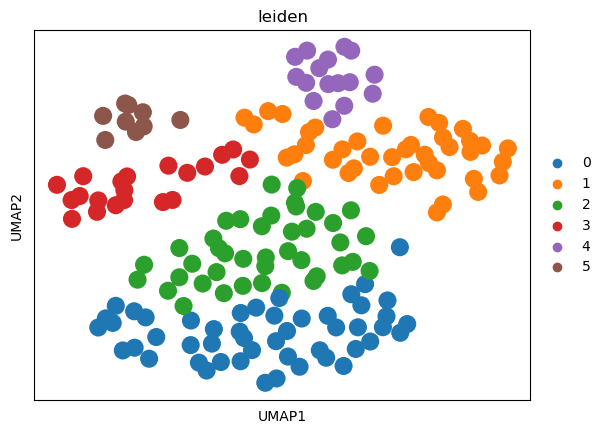

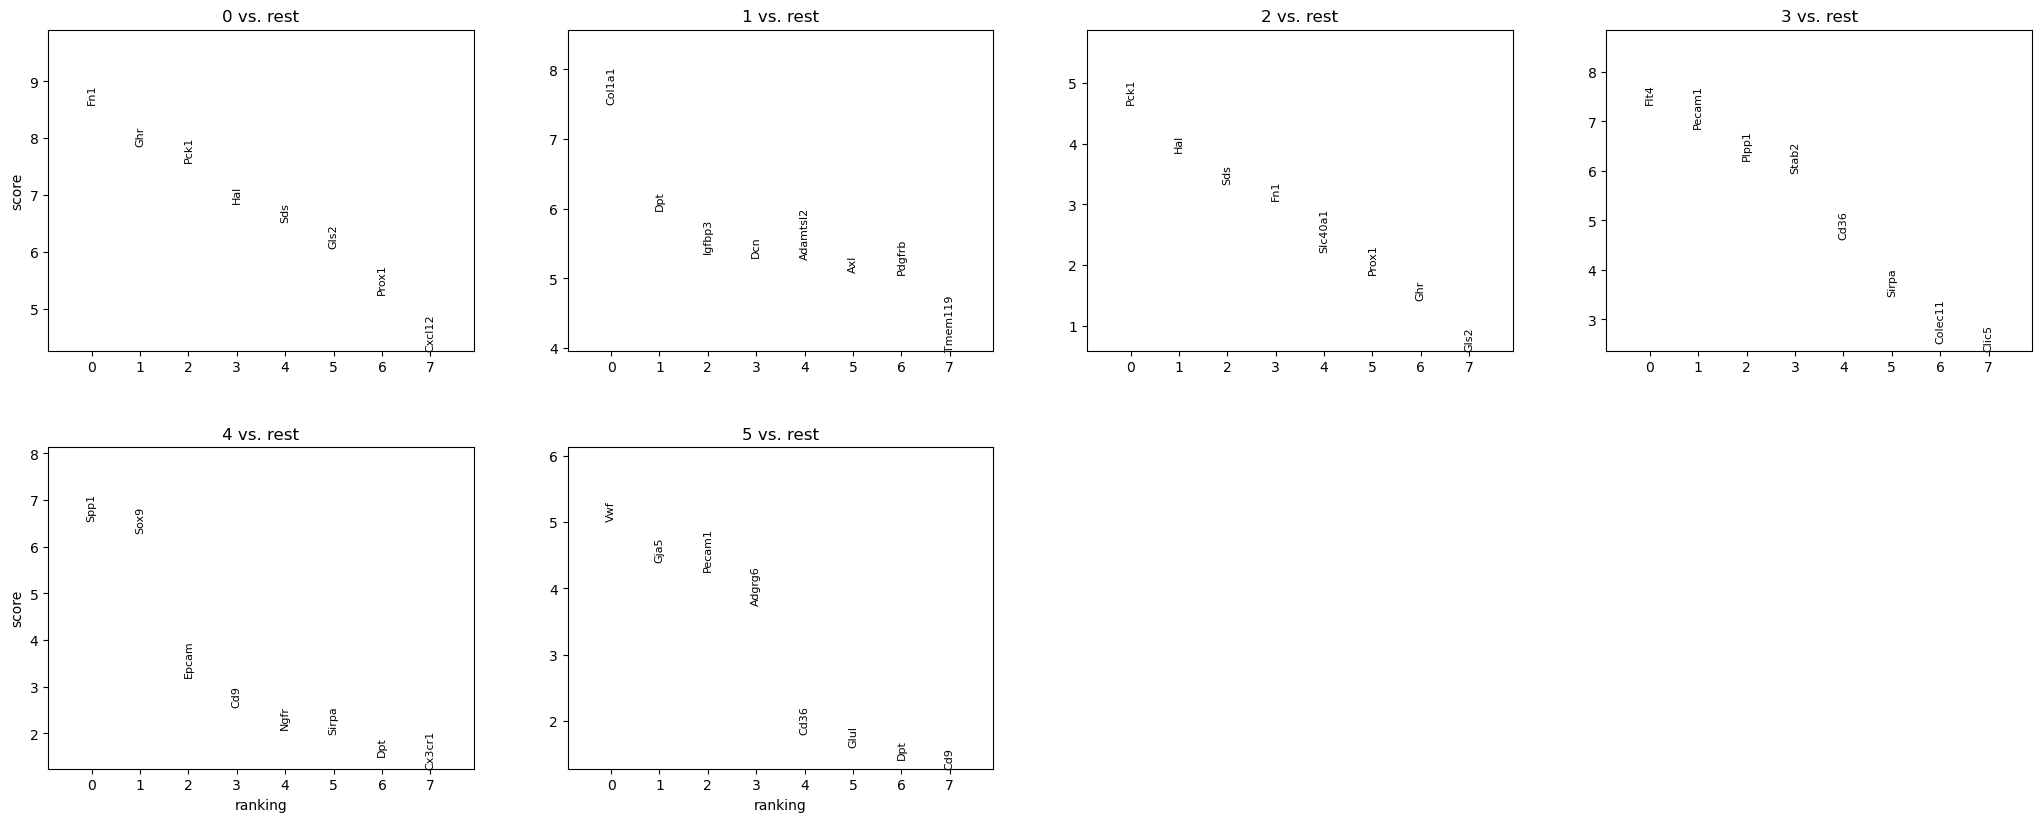

In [14]:
adata = fc.clustering(adata, 16, 30)
fc.clustering_plot(adata)

(0.8225447595119476,
 7.546916657686234,
 0.20192242860794063,
 10.124351727962495)

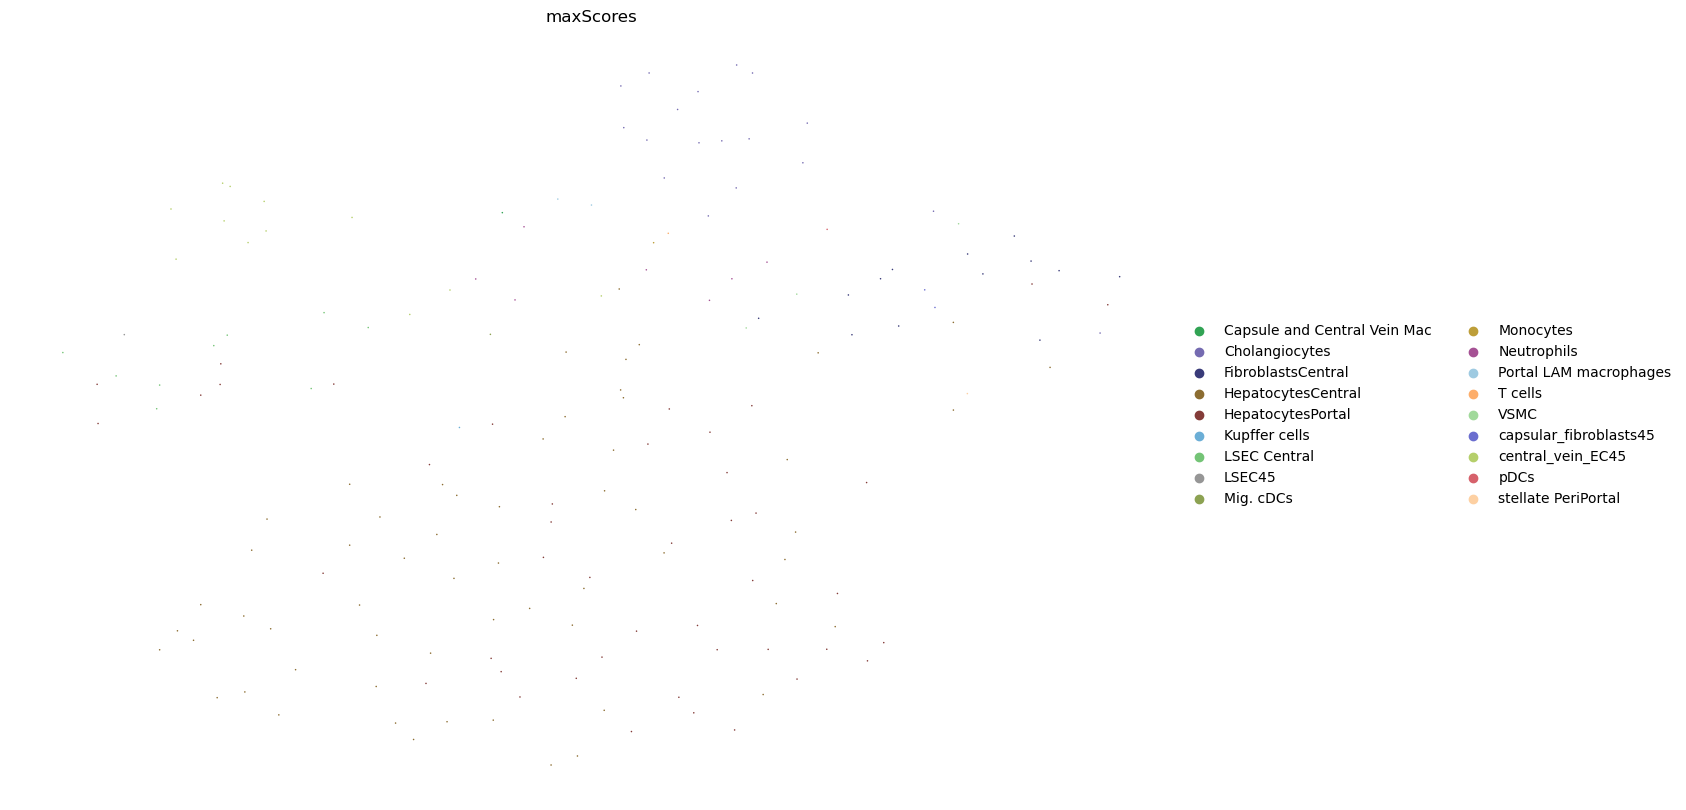

In [15]:
fig,ax =plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(adata,color=['maxScores'],ax=ax,size=5,show=False)
ax.axis('off')

(0.8225447595119476,
 7.546916657686234,
 0.20192242860794063,
 10.124351727962495)

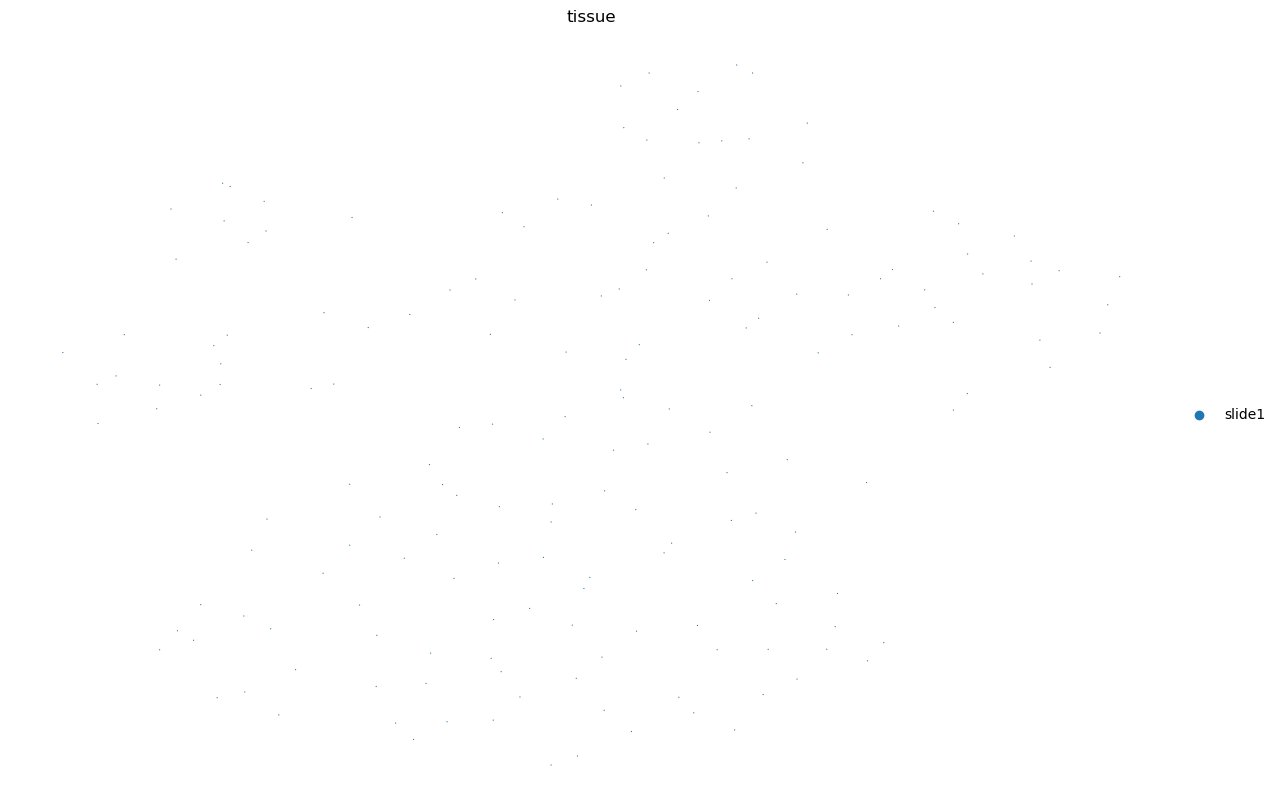

In [16]:
fig,ax =plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(adata, color=["tissue"],ax=ax,size=3,show=False)
ax.axis('off')

(0.8225447595119476,
 7.546916657686234,
 0.20192242860794063,
 10.124351727962495)

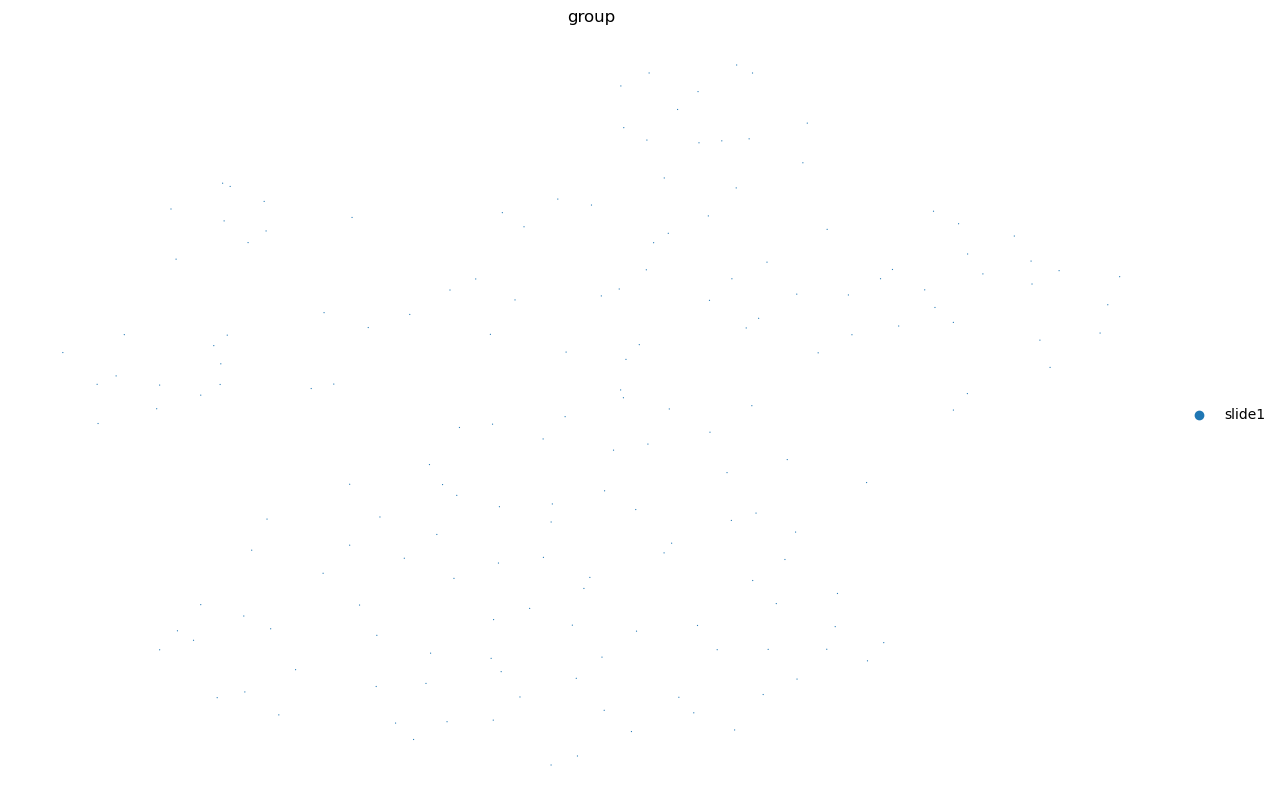

In [17]:
fig,ax =plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(adata, color=["group"],ax=ax,size=3,show=False)
ax.axis('off')

In [16]:
def get_markers(path_folder: str, folders: List[str]) -> str:
    run_folder = path_folder + "/" + folders[0] + "/"

    # Fetch markers file from config if exists
    if os.path.exists(run_folder + ".hydra/config.yaml"):
        with open(run_folder + ".hydra/config.yaml") as infile:
            data = yaml.load(infile, Loader=SafeLoader)
            return data["paths"]["data_dir"] + data["dataset"]["data_dir"].split("/")[1] + "/" + data["dataset"]["markers"].split("/")[1]
    else:
        print("Config file does not exist")

Marker file found /home/smon/Documents/unief/bio/design-project/napari-sparrow/data/resolve_liver/markerGeneListMartinNoLow.csv


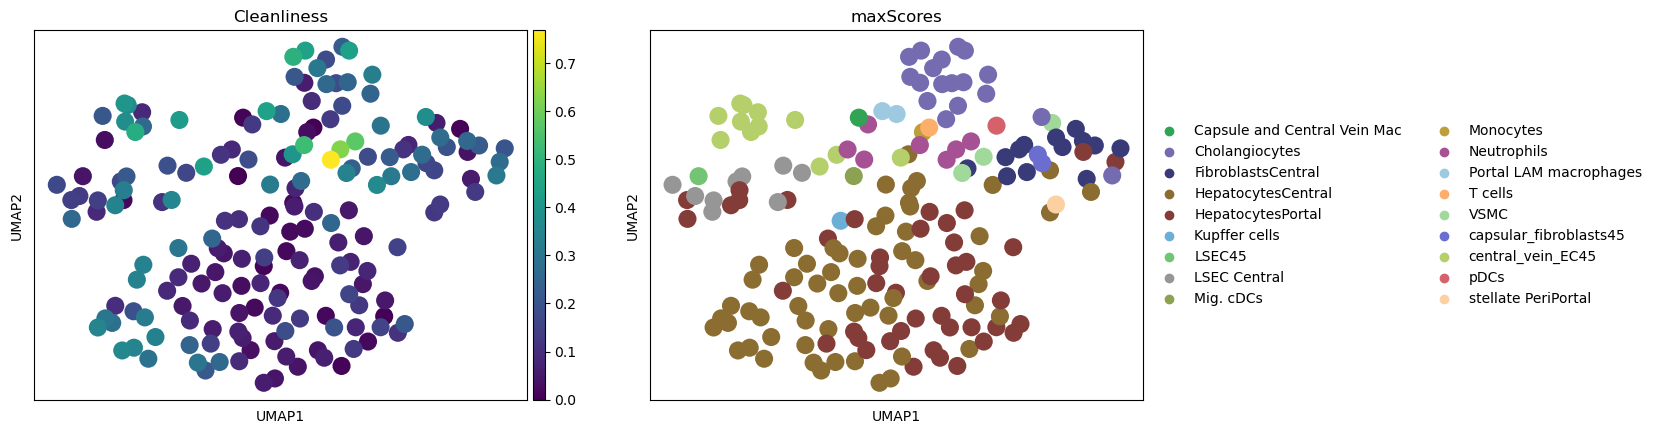

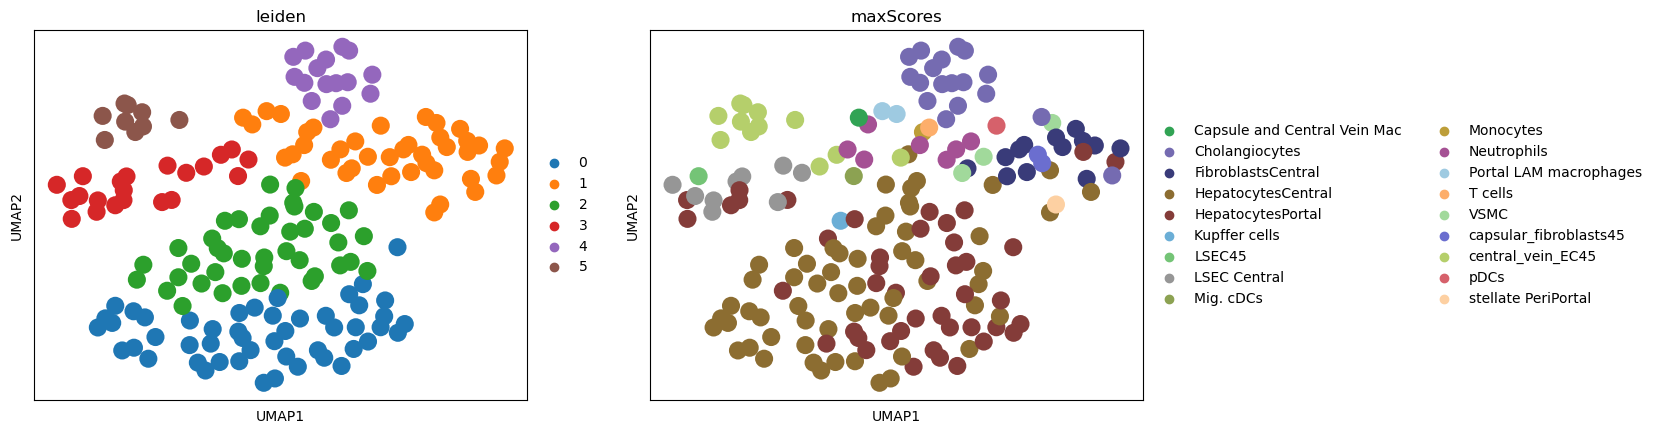

In [17]:
# broken as the data folder does not match up
# marker_file = get_markers(path_folder, folders)

marker_file = "/home/smon/Documents/unief/bio/design-project/napari-sparrow/data/resolve_liver/markerGeneListMartinNoLow.csv"

print("Marker file found " + marker_file)

# Supress _core_genes futerewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


mg_dict, scoresper_cluster = fc.scoreGenes(adata, marker_file)
sc.pl.umap(adata, color=["Cleanliness", "maxScores"])
sc.pl.umap(adata, color=["leiden", "maxScores"])

In [18]:
color_dict = fc.clustercleanliness(adata , list(mg_dict.keys()))

(0.8225447595119476,
 7.546916657686234,
 0.20192242860794063,
 10.124351727962495)

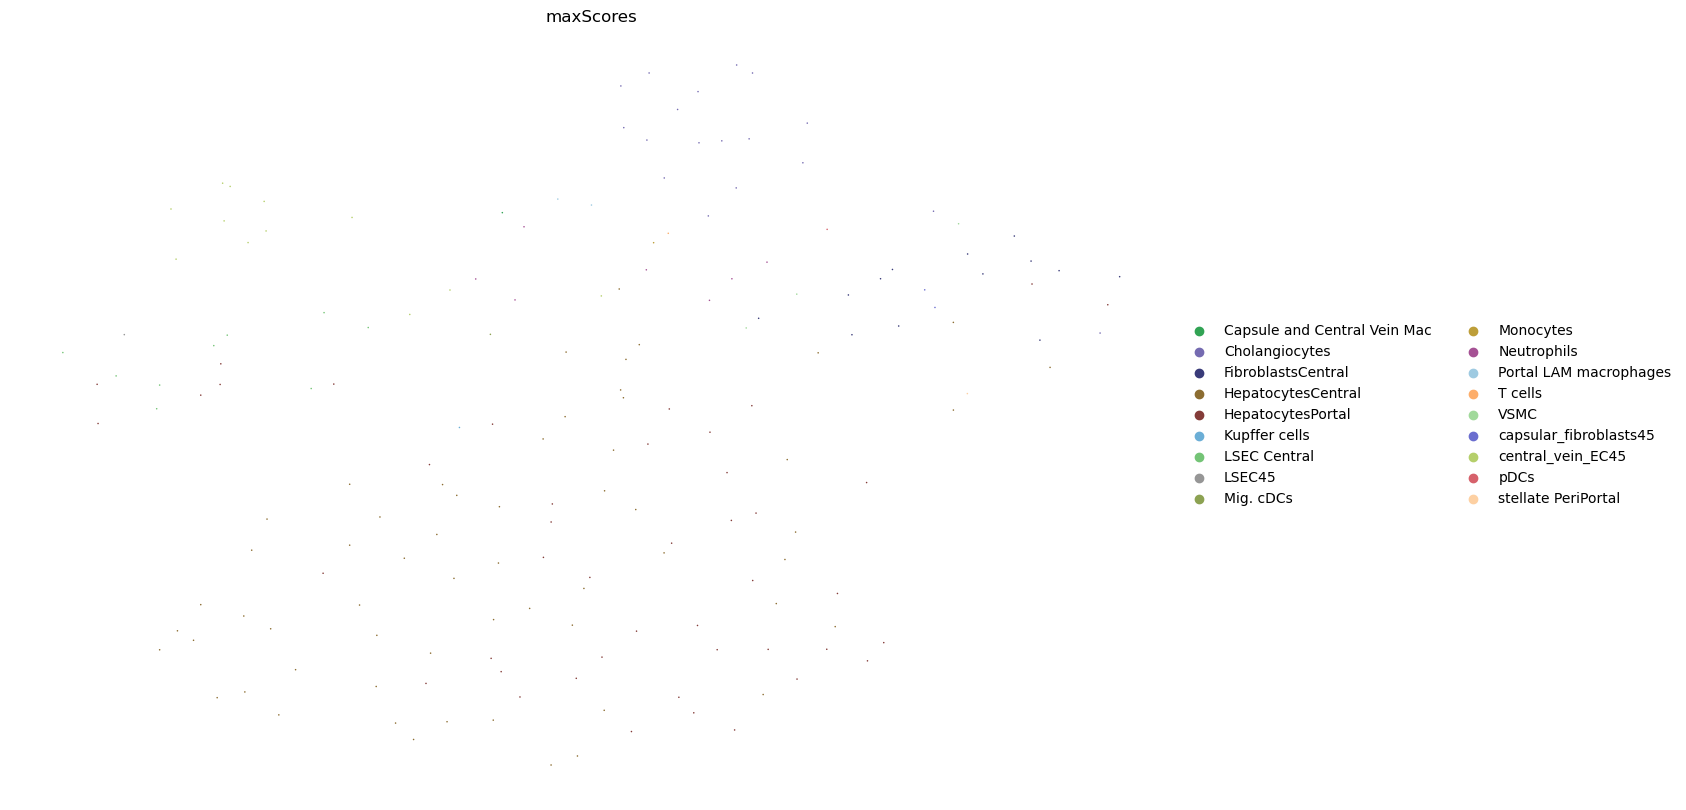

In [19]:
fig,ax =plt.subplots(1,1,figsize=(15,10))
sc.pl.umap(adata ,color=['maxScores'],ax=ax,size=5,show=False)
ax.axis('off')

In [20]:
adata.obs.tissue = adata.obs.tissue.astype('str').astype('category')
adata.write(path_folder + "/adata.h5ad")